# Liver Model

## Import some things

In [1]:
from Liver_Generator import Data_Generator, os, plot_scroll_Image, dice_coef_3D

Using TensorFlow backend.
c:\users\bmanderson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\bmanderson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\bmanderson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

In [2]:
%matplotlib notebook

In [3]:
data_path = os.path.join('..','Data','Niftii_Arrays')
train_path = os.path.join(data_path,'Train')
validation_path = os.path.join(data_path,'Validation')
test_path = os.path.join(data_path,'Test')

In [4]:
args = {'batch_size':5,'on_vgg':True}#'mean_val':81,'std_val':31,
train_generator = Data_Generator(train_path, shuffle=True, **args) # mean_val=81,std_val=30

7.14% Done loading
14.29% Done loading
21.43% Done loading
28.57% Done loading
35.71% Done loading
42.86% Done loading
50.0% Done loading
57.14% Done loading
64.29% Done loading
71.43% Done loading
78.57% Done loading
85.71% Done loading
92.86% Done loading
100.0% Done loading


## Normalize images about the mask to be mean 0, std 1

In [5]:
train_generator.get_mean_std_val() # This will calculate the mean and std for you and set it in the model
print(train_generator.mean_val)

Calculating mean and std...0% done
Calculating mean and std...0% done
Calculating mean and std...1% done
Calculating mean and std...1% done
Calculating mean and std...1% done
Calculating mean and std...1% done
Calculating mean and std...2% done
Calculating mean and std...2% done
Calculating mean and std...2% done
Calculating mean and std...2% done
Calculating mean and std...3% done
Calculating mean and std...3% done
Calculating mean and std...3% done
Calculating mean and std...4% done
Calculating mean and std...4% done
Calculating mean and std...4% done
Calculating mean and std...4% done
Calculating mean and std...5% done
Calculating mean and std...5% done
Calculating mean and std...5% done
Calculating mean and std...5% done
Calculating mean and std...6% done
Calculating mean and std...6% done
Calculating mean and std...6% done
Calculating mean and std...7% done
Calculating mean and std...7% done
Calculating mean and std...7% done
Calculating mean and std...7% done
Calculating mean and

Calculating mean and std...64% done
Calculating mean and std...64% done
Calculating mean and std...64% done
Calculating mean and std...65% done
Calculating mean and std...65% done
Calculating mean and std...65% done
Calculating mean and std...65% done
Calculating mean and std...66% done
Calculating mean and std...66% done
Calculating mean and std...66% done
Calculating mean and std...66% done
Calculating mean and std...67% done
Calculating mean and std...67% done
Calculating mean and std...67% done
Calculating mean and std...68% done
Calculating mean and std...68% done
Calculating mean and std...68% done
Calculating mean and std...68% done
Calculating mean and std...69% done
Calculating mean and std...69% done
Calculating mean and std...69% done
Calculating mean and std...70% done
Calculating mean and std...70% done
Calculating mean and std...70% done
Calculating mean and std...70% done
Calculating mean and std...71% done
Calculating mean and std...71% done
Calculating mean and std...7

In [6]:
args_val = {'on_vgg':True,'mean_val':train_generator.mean_val,'std_val':train_generator.std_val,'by_patient':True,
       'shuffle':True}#'mean_val':81,'
validation_generator = Data_Generator(validation_path, **args_val)
test_generator = Data_Generator(test_path, **args_val)

33.33% Done loading
66.67% Done loading
100.0% Done loading
33.33% Done loading
66.67% Done loading
100.0% Done loading


In [16]:
x,y = train_generator.__getitem__(0)

<IPython.core.display.Javascript object>


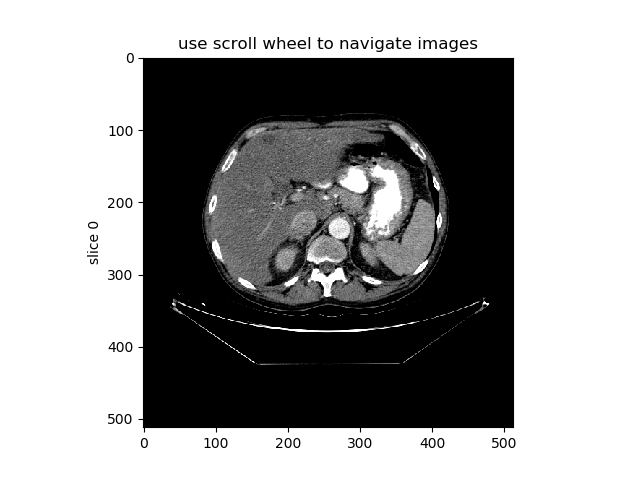

(<Figure size 640x480 with 1 Axes>,
 <Dicom_RT_and_Images_to_Mask.Image_Array_And_Mask_From_Dicom_RT.IndexTracker at 0x1734e6c6dc8>)

In [19]:
plot_scroll_Image(x[...,-1])

In [9]:
x,y = validation_generator.__getitem__(0)

### Alright, lets make our model!

In [10]:
from Easy_VGG16_UNet.Keras_Fine_Tune_VGG_16_Liver import VGG_16
from Visualizing_Model.Visualing_Model import visualization_model_class
from keras.optimizers import Adam

In [11]:
network = {'Layer_0': {'Encoding': [64, 64], 'Decoding': [32]},
           'Layer_1': {'Encoding': [128, 128], 'Decoding': [64]},
           'Layer_2': {'Encoding': [256, 256, 256], 'Decoding': [256]},
           'Layer_3': {'Encoding': [512, 512, 512], 'Decoding': [256]},
           'Layer_4': {'Encoding': [512, 512, 512]}}
VGG_model = VGG_16(network=network, activation='relu',filter_size=(3,3))
VGG_model.make_model()
VGG_model.load_weights()
new_model = VGG_model.created_model




Layer_3

Layer_2
Layer_1
Layer_0





In [13]:
Visualizing_Class = visualization_model_class(model=new_model, save_images=True, verbose=True)

block1_conv1
block1_conv1_activation
block1_conv2
block1_conv2_activation
block1_pool
block2_conv1
block2_conv1_activation
block2_conv2
block2_conv2_activation
block2_pool
block3_conv1
block3_conv1_activation
block3_conv2
block3_conv2_activation
block3_conv3
block3_conv3_activation
block3_pool
block4_conv1
block4_conv1_activation
block4_conv2
block4_conv2_activation
block4_conv3
block4_conv3_activation
block4_pool
block5_conv1
block5_conv1_activation
block5_conv2
block5_conv2_activation
block5_conv3
block5_conv3_activation
Upsampling0_UNet
concat0_Unet
Layer_3_Decoding_Conv0
Layer_3_Decoding_Conv0_activation
Upsampling1_UNet
concat1_Unet
Layer_2_Decoding_Conv0
Layer_2_Decoding_Conv0_activation
Upsampling2_UNet
concat2_Unet
Layer_1_Decoding_Conv0
Layer_1_Decoding_Conv0_activation
Upsampling3_UNet
concat3_Unet
Layer_0_Decoding_Conv0
Layer_0_Decoding_Conv0_activation
Output


In [14]:
Visualizing_Class.define_desired_layers(['block1_conv1','block1_conv1_activation','Output'])

In [20]:
Visualizing_Class.predict_on_tensor(x[0,...][None,...])

['block1_conv1', 'block1_conv1_activation', 'Output']
block1_conv1
0.0


<IPython.core.display.Javascript object>


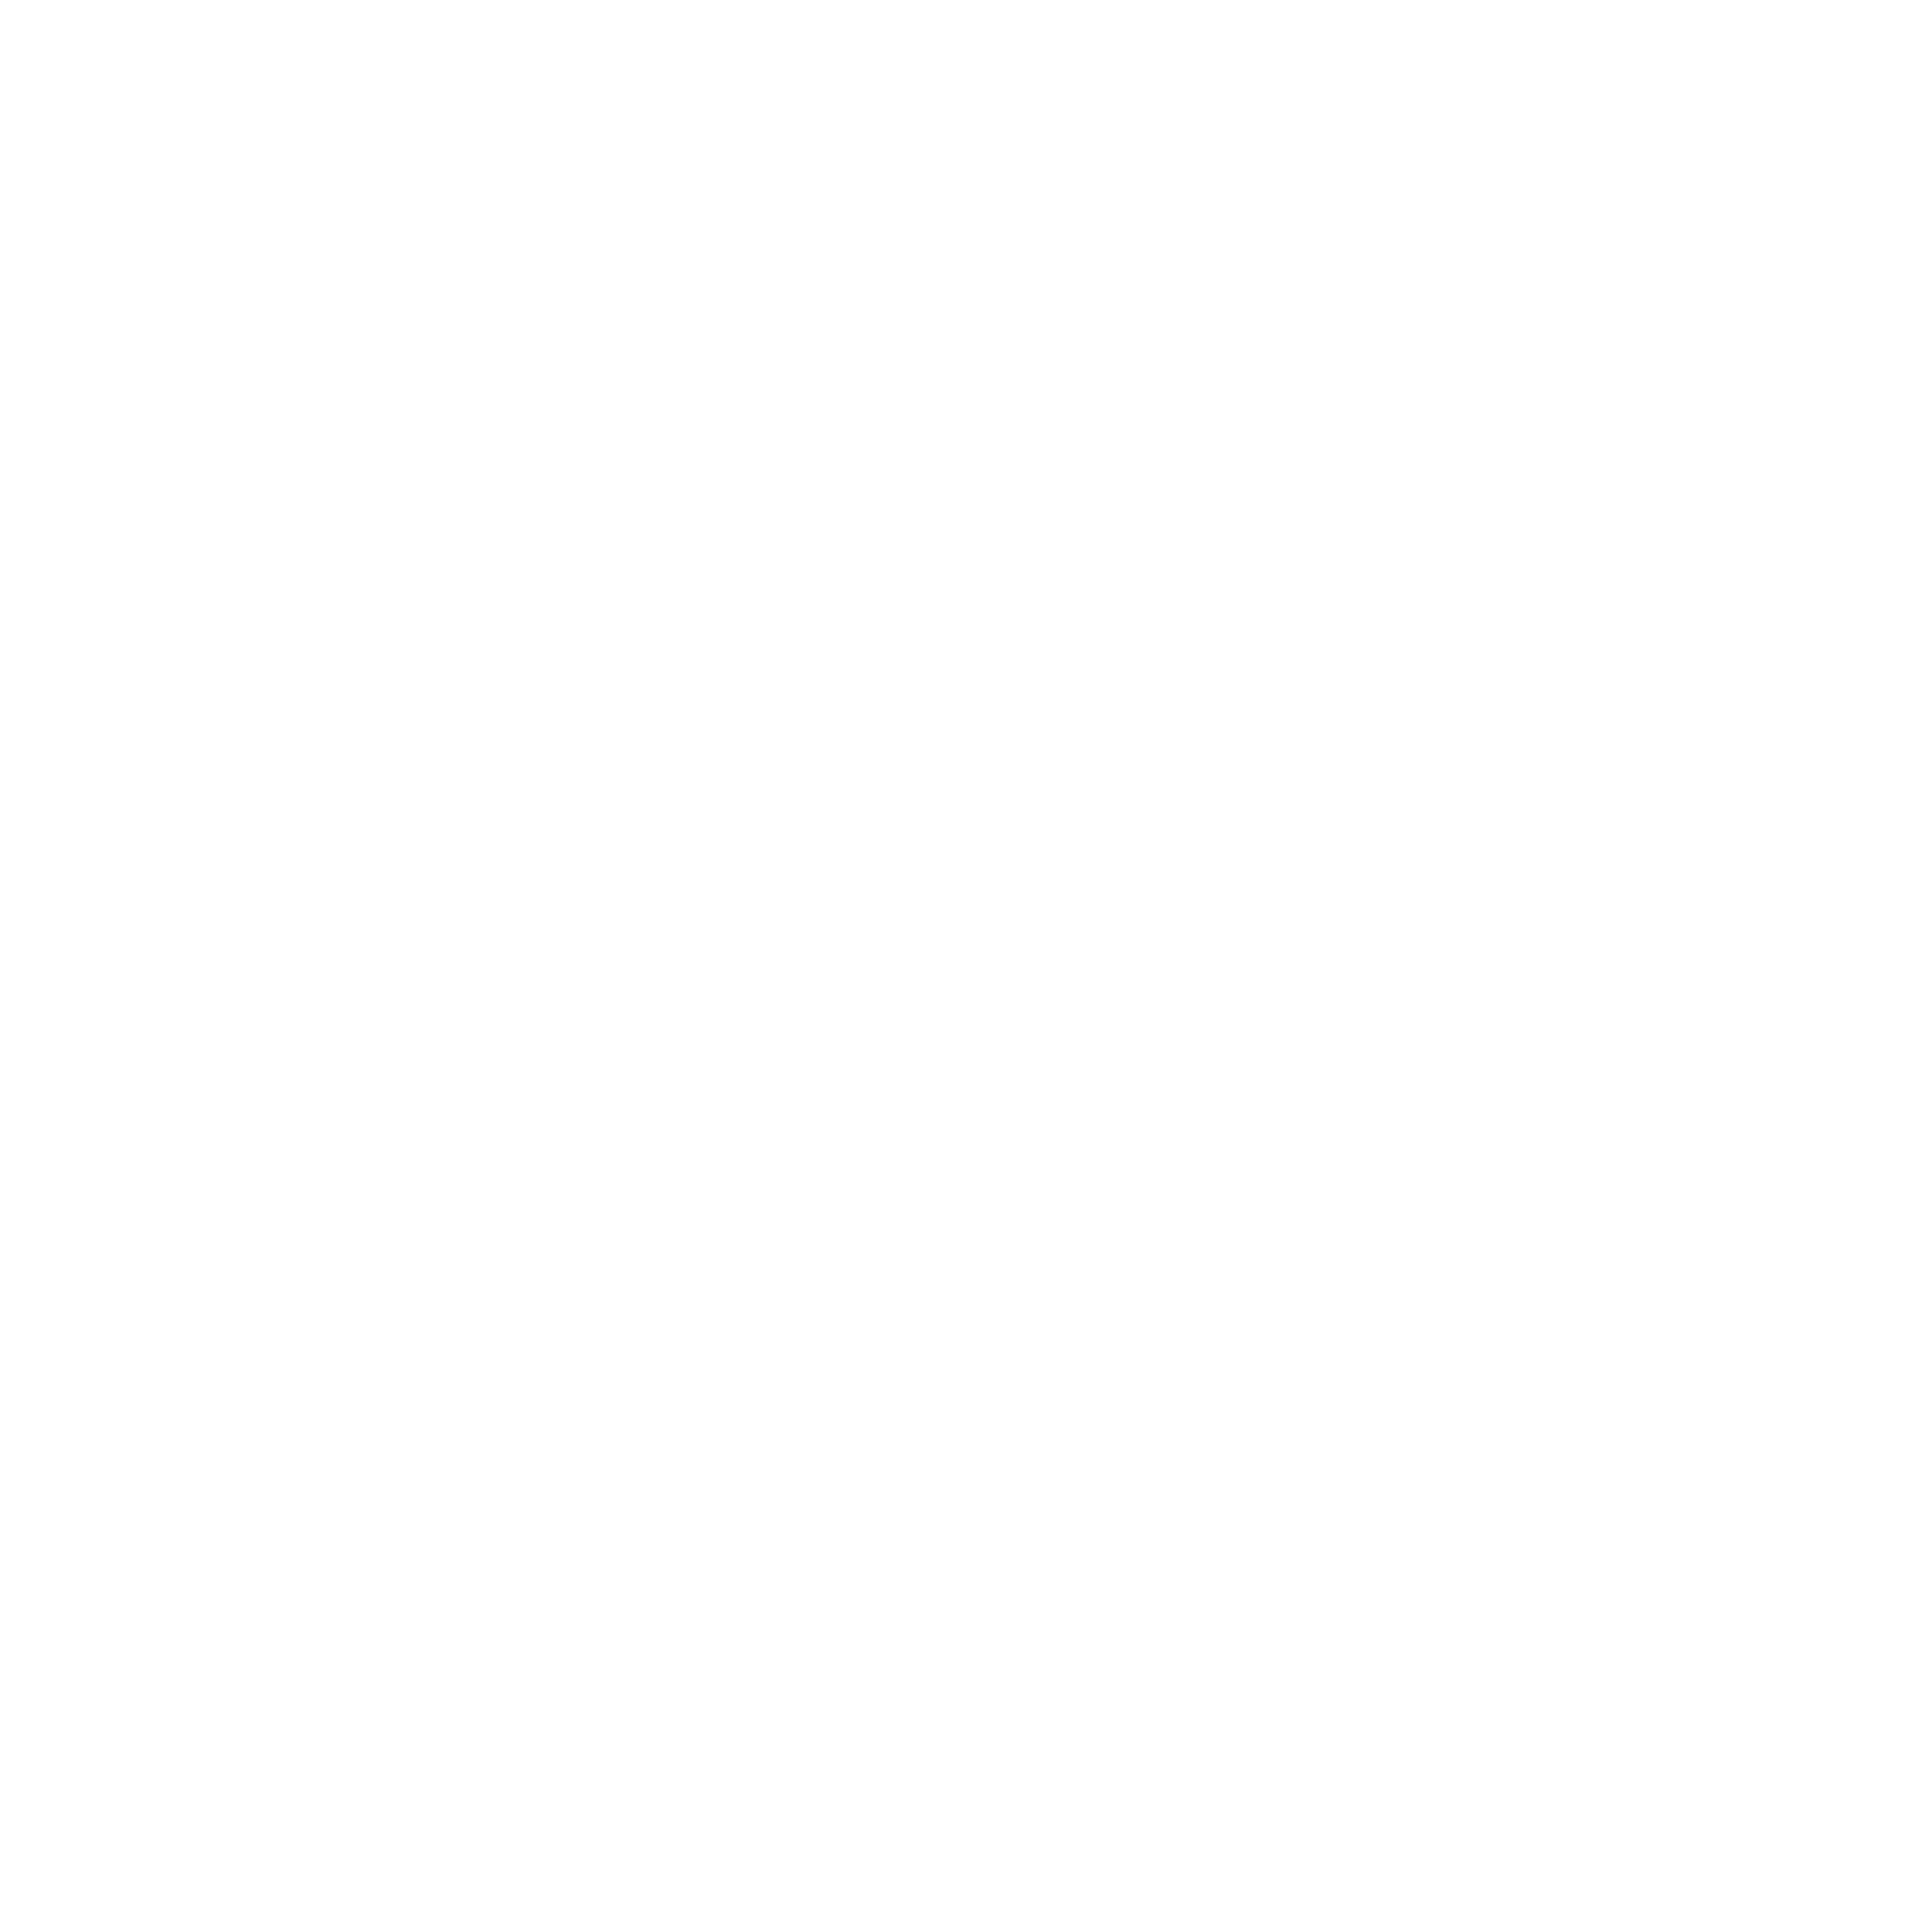

block1_conv1_activation
33.33333333333333


<IPython.core.display.Javascript object>


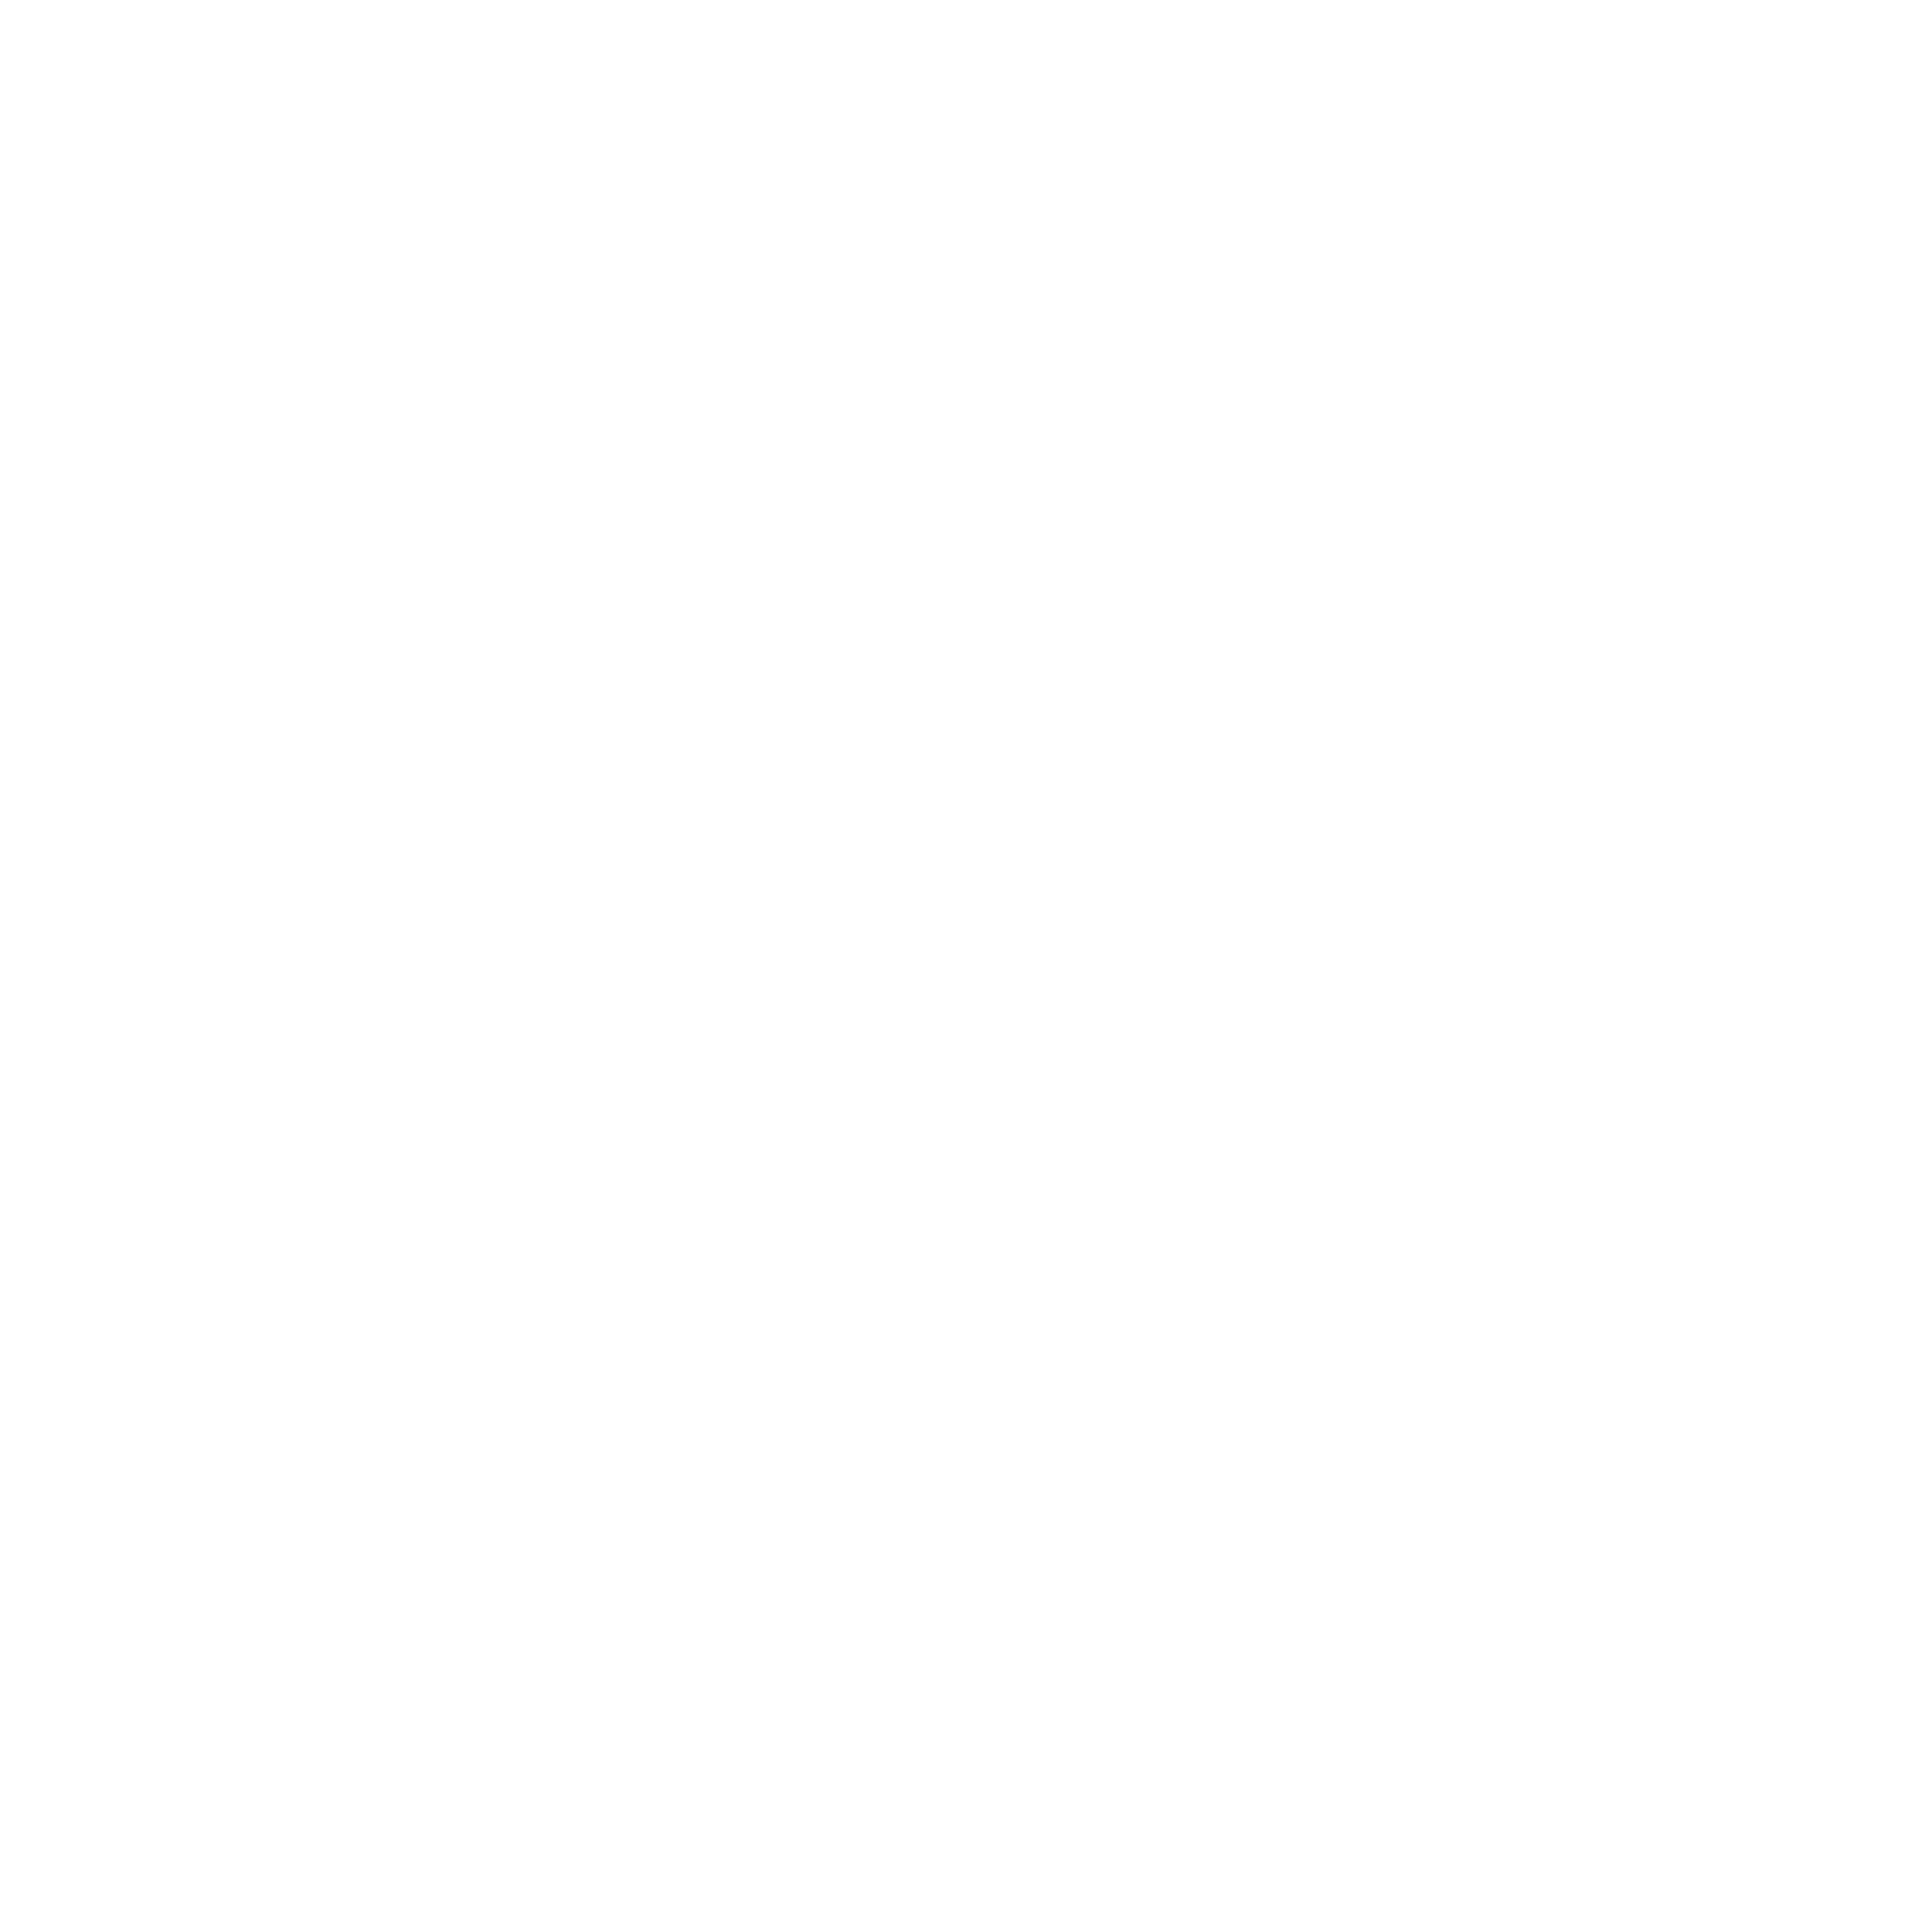

Output
66.66666666666666


<IPython.core.display.Javascript object>


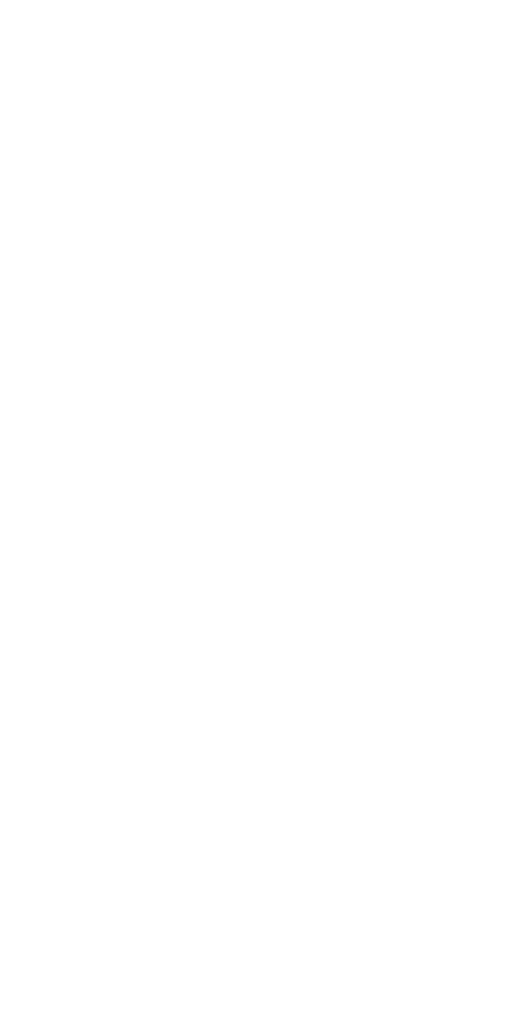

In [21]:
Visualizing_Class.plot_activations()

In [12]:
new_model.compile(Adam(lr=5e-5),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

In [ ]:
def freeze_until_name(model,name):
    set_trainable = False
    for layer in model.layers:
        if layer.name == name:
            set_trainable = True
        layer.trainable = set_trainable
    return model
new_model = freeze_until_name(new_model,'Upsampling0_UNet')

In [ ]:
new_model.fit_generator(train_generator,epochs=5, workers=20, max_queue_size=50, validation_data=validation_generator)

In [ ]:
x,y = validation_generator.__getitem__(0)

In [ ]:
pred = new_model.predict(x)

In [ ]:
pred[pred<0.5] = 0
pred[pred>0] = 1

In [ ]:
plot_scroll_Image(pred[...,1])